In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions
!pip install datasets
!pip install pytorch_lightning
!pip install transformers

import tensorflow as tf
import torch

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
import numpy as np
import re
import string
import math
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from pylab import rcParams
from matplotlib import rc
import seaborn as sns
import matplotlib.pyplot as plt
import os



%matplotlib inline
%config InlineBackend.figure_format='retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 45.7 MB/s 
     |████████████████████████████████| 110 kB 71.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 23.4 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 
     |████████████████████████████████| 212 kB 74.6 MB/s 
     |████████████████████████████████| 132 kB 73.7 MB/s 
     |████████████████████████████████| 127 kB 66.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 18.9 MB/s 
     |████████████████████████████████| 125 kB 77.4 MB/s 
     |████████████████

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/MINI PROJECT/MOLD_train.tsv', sep='\t')
df1

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NaN,NaN
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NaN,NaN
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NaN,NaN
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NaN,NaN
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NaN,NaN
...,...,...,...,...,...
3098,3098,@USER सगळ्यात जास्त वास मारणारी पुच्ची,OFF,UNT,NaN
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,OFF,TIN,OTH
3100,3100,@USER पुच्ची कप्तान साब,OFF,TIN,OTH
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,OFF,TIN,OTH


In [ ]:
df1=df1.fillna("NOT")
df1

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NOT,NOT
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NOT,NOT
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NOT,NOT
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NOT,NOT
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NOT,NOT
...,...,...,...,...,...
3098,3098,@USER सगळ्यात जास्त वास मारणारी पुच्ची,OFF,UNT,NOT
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,OFF,TIN,OTH
3100,3100,@USER पुच्ची कप्तान साब,OFF,TIN,OTH
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,OFF,TIN,OTH


In [ ]:
df1.iloc[[1981]]

,id,tweet,subtask_a,subtask_b,subtask_c
1981,1981,अहो मग आता जेव्हा कंगना नि इतका काही बोलली मुं...,OFF,NOT,NOT


In [ ]:
df1=df1.drop(df1.index[1981])
df1

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NOT,NOT
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NOT,NOT
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NOT,NOT
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NOT,NOT
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NOT,NOT
...,...,...,...,...,...
3098,3098,@USER सगळ्यात जास्त वास मारणारी पुच्ची,OFF,UNT,NOT
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,OFF,TIN,OTH
3100,3100,@USER पुच्ची कप्तान साब,OFF,TIN,OTH
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,OFF,TIN,OTH


In [ ]:
df1[(df1['subtask_a']=="OFF") & (df1['subtask_b']=="UNT")]

,id,tweet,subtask_a,subtask_b,subtask_c
1982,1982,उद्धव ठाकरे यांना एकेरी संबोधलं म्हणून हक्कभंग...,OFF,UNT,NOT
1983,1983,च्यायला म्हणजे दुबईचा फोन ही पुडीच निघाली की,OFF,UNT,NOT
1984,1984,ह्या असल्या दळभद्री लोकांना अक्कल शिकवायला हवी...,OFF,UNT,NOT
1985,1985,बावळट कुठले काहीही तर्क लावतेत की डाळ,OFF,UNT,NOT
1986,1986,तिने तोंड उघडलं ह्यांनी नाक दाबायला सुरुवात केली,OFF,UNT,NOT
...,...,...,...,...,...
3032,3032,चायला हा मराठीत कधी पासून ट्विट करायला लागला ?...,OFF,UNT,NOT
3059,3059,मदत तातडीने द्यायला हवी महिने अधिकारी गोट्या ख...,OFF,UNT,NOT
3060,3060,@USER @USER @USER @USER @USER रंगा बिल्ला ने श...,OFF,UNT,NOT
3066,3066,@USER काही लोकं अजूनही म्हणतात की पूर आल्यावर ...,OFF,UNT,NOT


In [ ]:
 df1[(df1['subtask_a']==df1['subtask_b'])]

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NOT,NOT
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NOT,NOT
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NOT,NOT
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NOT,NOT
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NOT,NOT
...,...,...,...,...,...
3093,3093,@USER कितीही काही झाले तरी ही माझा पहिला सुपर ...,NOT,NOT,NOT
3094,3094,@USER @USER झकास शिवानी,NOT,NOT,NOT
3095,3095,@USER डिश मात्र झकास आहेएकदम मिसळ हाऊस वाला फिल,NOT,NOT,NOT
3096,3096,जांभूळ पाडा म्हणजे खवय्येगिरी करण्यासाठी एकदम ...,NOT,NOT,NOT


In [ ]:
print(len(df1[(df1['subtask_a']=='NOT')]))
print(len(df1[(df1['subtask_b']=='NOT')]))
print(len(df1[(df1['subtask_c']=='NOT')]))

2034
2034
2362


In [ ]:
df1[(df1['subtask_c']!='NOT')]

,id,tweet,subtask_a,subtask_b,subtask_c
1451,1451,राम कदम वागण्यात नाही तर बोलण्यात चुकला बीजेपी...,OFF,TIN,GRP
1452,1452,हीच का तुमची शिवसेने चि शिकवण आपली आई म्हणजे द...,OFF,TIN,GRP
1453,1453,हे वाचा गाढवांनो आणि हे ही सांगा की तुमच्या मॅ...,OFF,TIN,GRP
1454,1454,भक्त आंधळे असतात मूर्खा ना काही कळत नाही,OFF,TIN,GRP
1455,1455,१९६६ साली छत्रपती शिवाजी महाराज या जागतिक दर्ज...,OFF,TIN,GRP
...,...,...,...,...,...
3064,3064,@USER @USER हो रे साहेबचा गोट्या,OFF,TIN,OTH
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,OFF,TIN,OTH
3100,3100,@USER पुच्ची कप्तान साब,OFF,TIN,OTH
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,OFF,TIN,OTH


In [ ]:
df1[(df1['subtask_a']==df1['subtask_b']) & (df1['subtask_b']==df1['subtask_c']) & (df1['subtask_c']==df1['subtask_a'])]

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NOT,NOT
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NOT,NOT
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NOT,NOT
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NOT,NOT
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NOT,NOT
...,...,...,...,...,...
3093,3093,@USER कितीही काही झाले तरी ही माझा पहिला सुपर ...,NOT,NOT,NOT
3094,3094,@USER @USER झकास शिवानी,NOT,NOT,NOT
3095,3095,@USER डिश मात्र झकास आहेएकदम मिसळ हाऊस वाला फिल,NOT,NOT,NOT
3096,3096,जांभूळ पाडा म्हणजे खवय्येगिरी करण्यासाठी एकदम ...,NOT,NOT,NOT


In [ ]:
df1[(df1['subtask_a']!=df1['subtask_b']) & (df1['subtask_b']==df1['subtask_c'])]

,id,tweet,subtask_a,subtask_b,subtask_c


In [ ]:
print(df1['tweet'][0]+"\n")
print(df1['tweet'][45]+"\n")
print(df1['tweet'][88]+"\n")

आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन आले होते २०१६ साली भाजपचे तत्कालीन…

सन २०२० २०२१ या वर्षात मराठा समाजाला नोकऱ्या आणि शैक्षणिक संस्थामध्ये आरक्षणाचा लाभ मिळणार नाही …

म्हणून गप्प आहेत?????? मान…



In [ ]:
train_df=df1
train_df

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NOT,NOT
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NOT,NOT
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NOT,NOT
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NOT,NOT
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NOT,NOT
...,...,...,...,...,...
3098,3098,@USER सगळ्यात जास्त वास मारणारी पुच्ची,OFF,UNT,NOT
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,OFF,TIN,OTH
3100,3100,@USER पुच्ची कप्तान साब,OFF,TIN,OTH
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,OFF,TIN,OTH


In [ ]:
train_df.drop_duplicates(inplace=True)
train_df

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,NOT,NOT,NOT
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,NOT,NOT,NOT
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,NOT,NOT,NOT
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,NOT,NOT,NOT
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,NOT,NOT,NOT
...,...,...,...,...,...
3098,3098,@USER सगळ्यात जास्त वास मारणारी पुच्ची,OFF,UNT,NOT
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,OFF,TIN,OTH
3100,3100,@USER पुच्ची कप्तान साब,OFF,TIN,OTH
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,OFF,TIN,OTH


In [ ]:
a=list(train_df['subtask_a'])
temp=[]
for i in a:
  if(i=='NOT'):
    temp.append(0)
  else:
    temp.append(1)

train_df['subtask_a']=temp

In [ ]:
b=list(train_df['subtask_b'])
temp=[]
for i in b:
  if(i=='NOT'):
    temp.append(0)
  elif(i=='UNT'):
    temp.append(1)
  elif(i=='TIN'):
    temp.append(2)
train_df['subtask_b']=temp

In [ ]:
c=list(train_df['subtask_c'])
temp=[]
for i in c:
  if(i=='NOT'):
    temp.append(0)
  elif(i=='IND'):
    temp.append(1)
  elif(i=='GRP'):
    temp.append(2)
  elif(i=='OTH'):
    temp.append(3)

train_df['subtask_c']=temp

In [ ]:
train_df

,id,tweet,subtask_a,subtask_b,subtask_c
0,0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...,0,0,0
1,1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुण...,0,0,0
2,2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आम...,0,0,0
3,3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाष...,0,0,0
4,4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब ...,0,0,0
...,...,...,...,...,...
3098,3098,@USER सगळ्यात जास्त वास मारणारी पुच्ची,1,1,0
3099,3099,@USER दोन नंबर पुच्ची पाकळ्या मस्त आहेत चाटायल...,1,2,3
3100,3100,@USER पुच्ची कप्तान साब,1,2,3
3101,3101,@USER नंबरकाळी पुच्ची आणि वर थोडे केसखालून चाट...,1,2,3


In [ ]:
#replacing " ' " with an emptyspace
train_df['tweet'] = [re.sub("'",'',str(x)) for x in train_df['tweet']]

In [ ]:
#removing the punctuations
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text

train_df['tweet'] = remove_punc(train_df['tweet'])

In [ ]:
# removing the digits 
train_df['tweet'] = [re.sub("[२३०८१५७९४६]","",x) for x in train_df['tweet']]
#removing emojis from the sentence
train_df['tweet'] = [re.sub("[\u200d]","",x) for x in train_df['tweet']]

In [ ]:
# removing the starting and ending whitespaces
train_df['tweet'] = [x.strip() for x in train_df['tweet']]

In [ ]:
print(df1['tweet'][0]+"\n")
print(df1['tweet'][45]+"\n")
print(df1['tweet'][88]+"\n")

आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन आले होते  साली भाजपचे तत्कालीन…

सन   या वर्षात मराठा समाजाला नोकऱ्या आणि शैक्षणिक संस्थामध्ये आरक्षणाचा लाभ मिळणार नाही …

म्हणून गप्प आहेत मान…



In [ ]:
print(train_df['tweet'][0]+"\n")
print(train_df['tweet'][45]+"\n")
print(train_df['tweet'][88]+"\n")

आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन आले होते  साली भाजपचे तत्कालीन…

सन   या वर्षात मराठा समाजाला नोकऱ्या आणि शैक्षणिक संस्थामध्ये आरक्षणाचा लाभ मिळणार नाही …

म्हणून गप्प आहेत मान…



In [ ]:
temp_df=train_df
train, test = train_test_split(temp_df, test_size=0.2,random_state=19)

In [ ]:
train

,id,tweet,subtask_a,subtask_b,subtask_c
2321,2321,USER तू ला माहीत होत पुर येणार तर येडझवया त्या...,1,2,1
2354,2354,USER तुमच्या पक्षाचे काय झाले ते बघा आधी मंद,1,2,2
2885,2885,USER USER तू अतिशय चांगला माणूस आहेबकीच्यांचा ...,0,0,0
1129,1129,सुशांत बिहारचा रिया बंगलोरची कंगना हिमाचल प्रद...,0,0,0
148,148,साखर पडो तुमच्या तोंडातखरंच असे झाले असते तर,0,0,0
...,...,...,...,...,...
936,936,गीत भिमा तुझ्यासाठी कुंकवाचा धनी ज्ञानरवि विद्...,0,0,0
1378,1378,USER काेभिड महामारीको बेला आफ्नै राज्यका फ्रन्...,0,0,0
757,757,थोडे वेडे व्हा व्हा थोडे वेडे अगदीच नुसतेच अन्...,0,0,0
2671,2671,आंधळा माणूस एका मंदिरात गेला मंदिरात दर्शन घेत...,0,0,0


In [ ]:
test

,id,tweet,subtask_a,subtask_b,subtask_c
2656,2656,USER चांगला आहे का,0,0,0
2320,2320,USER USER मंत्री आहे चुतीया मंत्री आहे राहतो क...,1,2,1
1503,1503,आणि त्या दक्षिण भारतातील लोकांचे विचार एकदम बा...,1,2,2
3058,3058,USER USER वडनगरला चहा विकून पैसे दिलंय का चमन ...,1,2,3
2229,2229,च्यायला अन्याय आहे हा,1,1,0
...,...,...,...,...,...
591,591,माफ करा माफ करा थोड्या जास्त ट्विट केल्या या व...,0,0,0
2418,2418,USER एकदम चुप नालायक,1,2,3
1923,1923,तुजाईला माझा लवडा लई आवडतो सारखा तोंडात ठेवते ...,1,2,1
2009,2009,डुक्कर शब्द वापरलाज्यांचे काही राजकारणी लांग...,1,1,0


In [ ]:
train.shape,test.shape

((2481, 5), (621, 5))

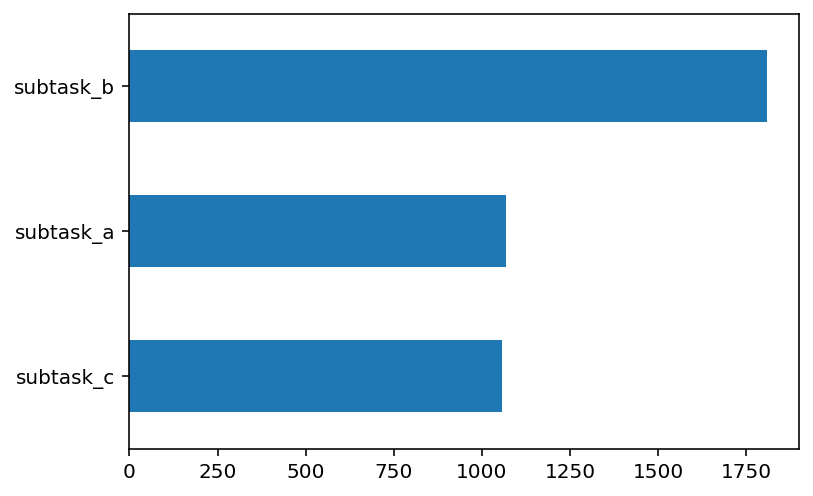

In [ ]:
LABEL_COLUMNS = train_df.columns.tolist()[2:]
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


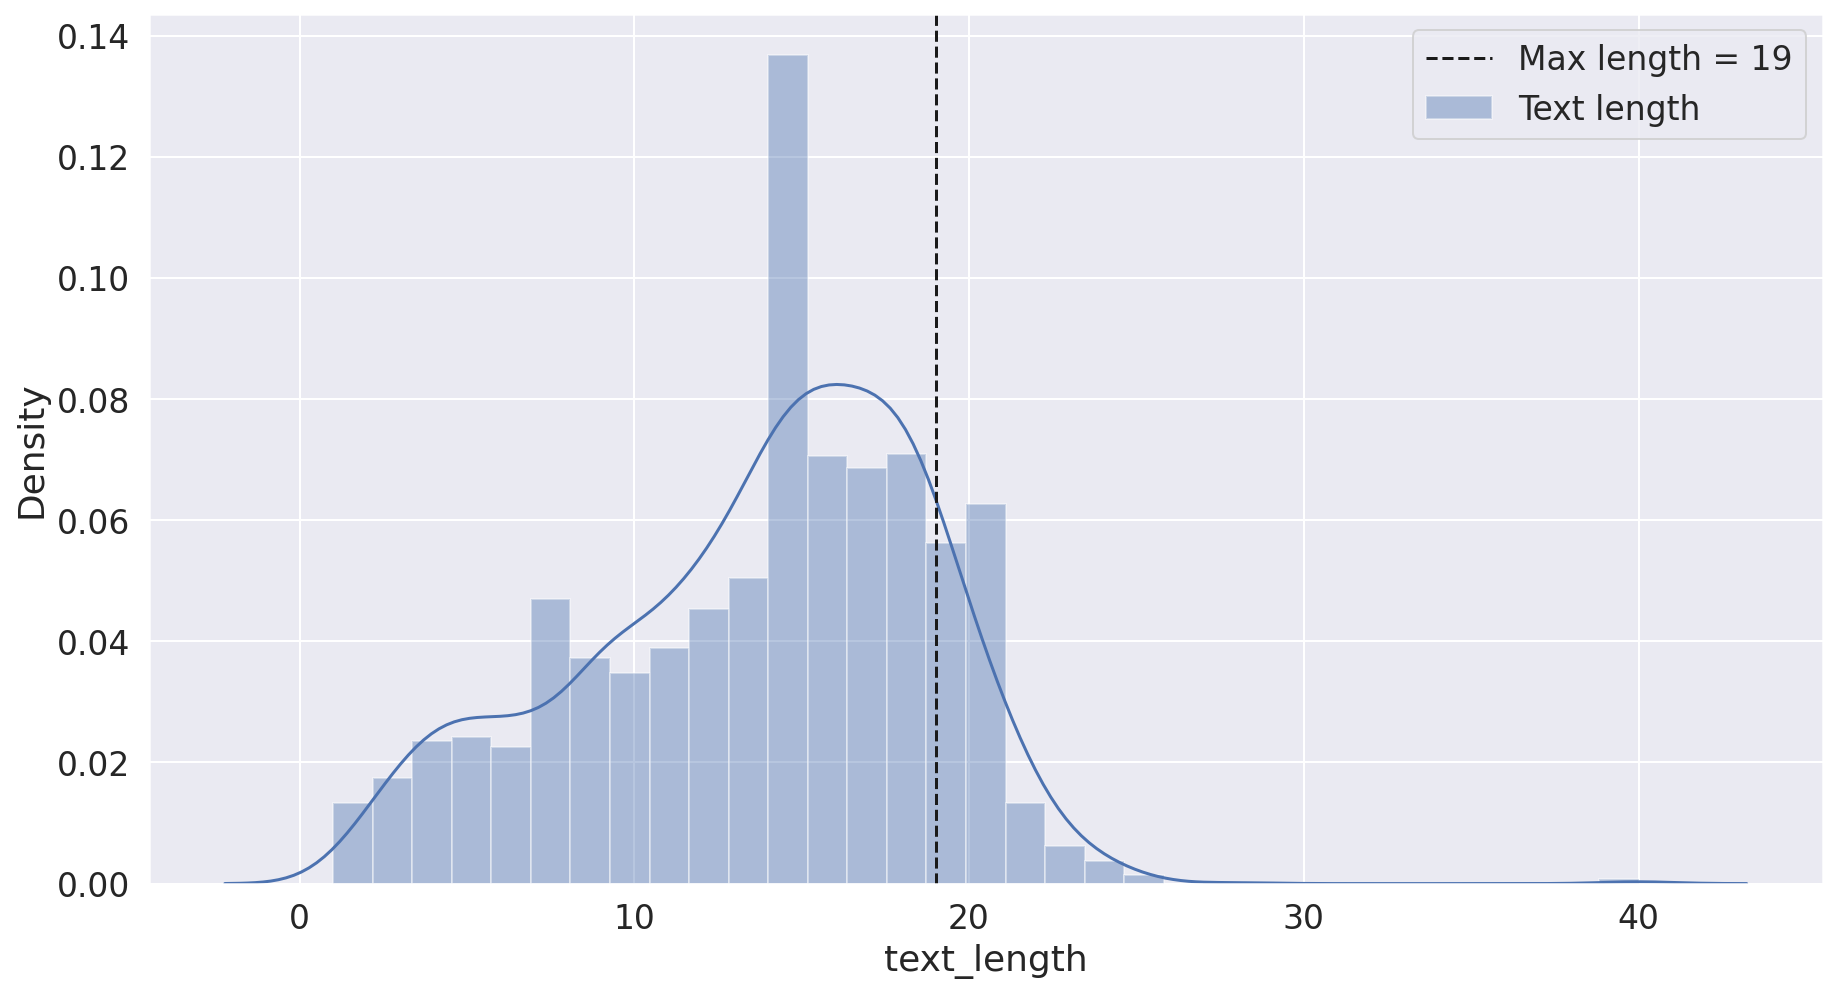

In [ ]:
train["text_length"] = train["tweet"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train["text_length"].mean() + train["text_length"].std()).astype(int)

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.distplot(train["text_length"], hist=True, kde=True, color='b', label='Text length')
label = 'Max length = {}'.format(max_seq_len)
plt.axvline(x=max_seq_len, color='k', linestyle='--', label=label)
plt.legend()
plt.show()

#free space
del train["text_length"]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


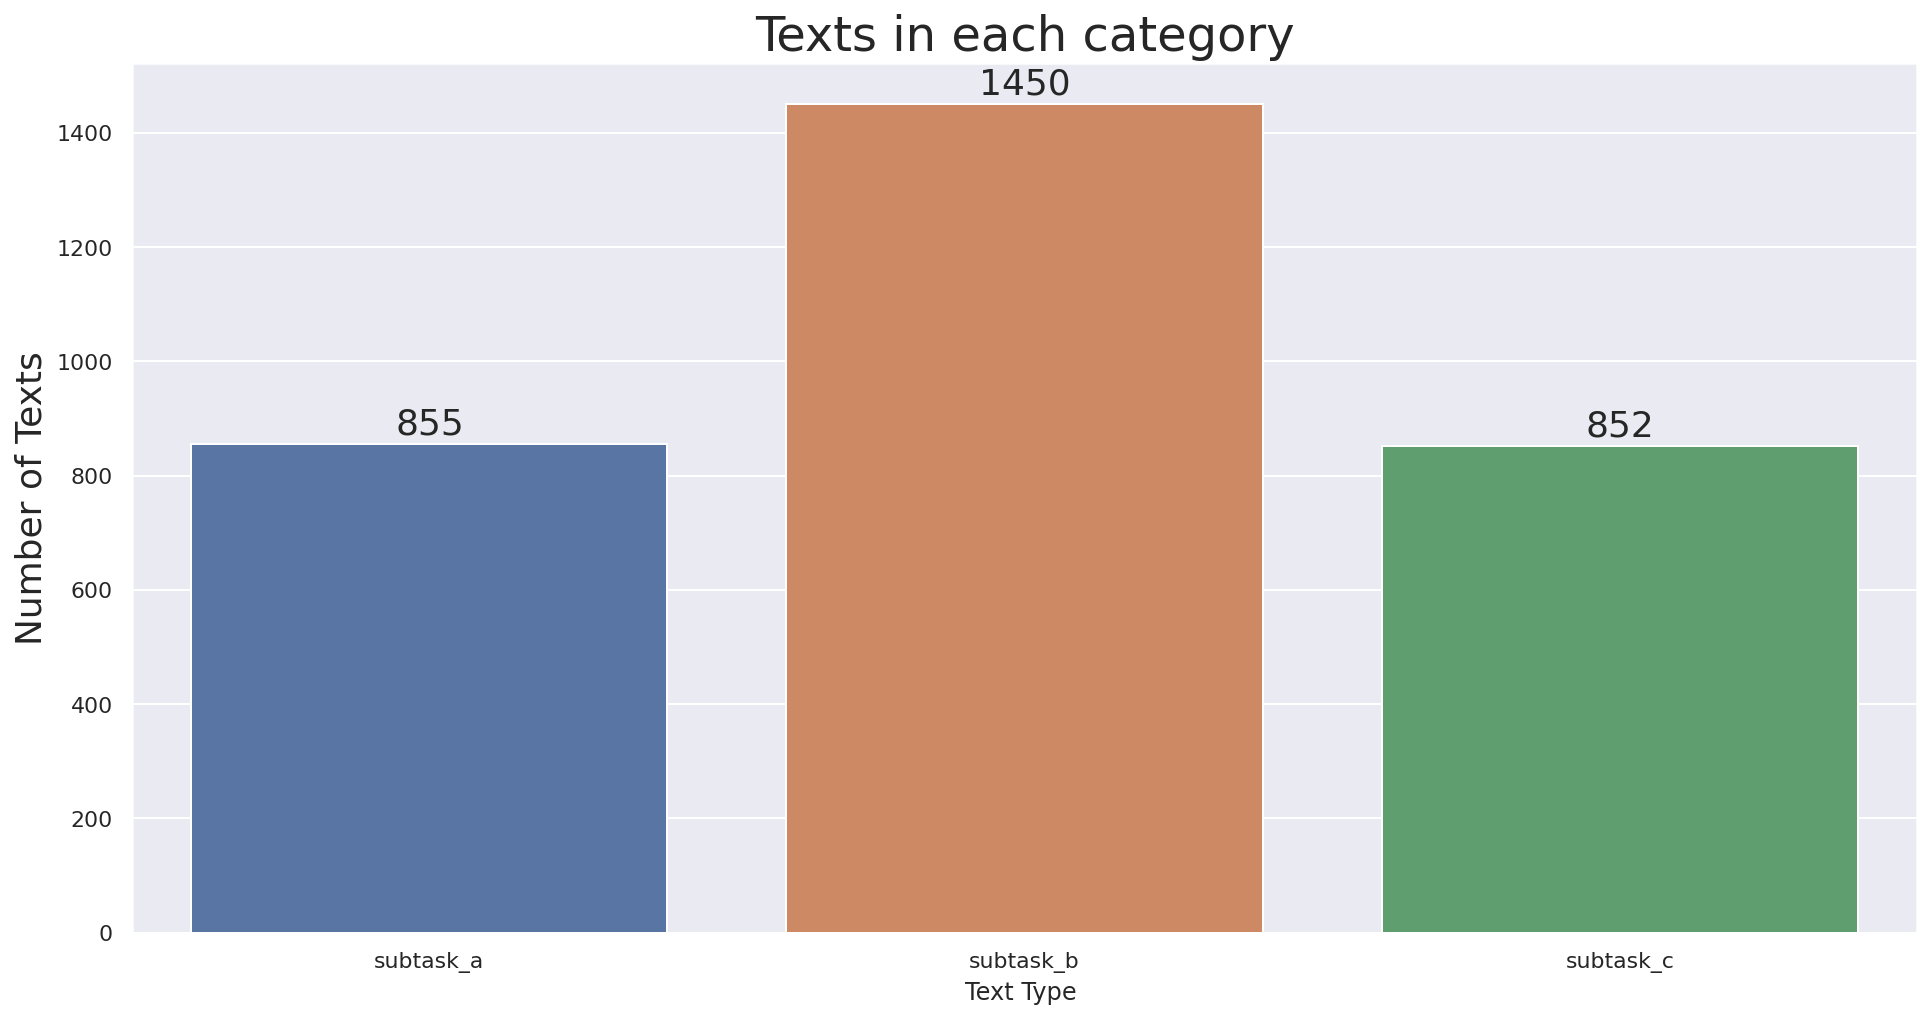

In [ ]:
list_classes = list(train.columns[2:].values)
num_classes = len(list_classes)
y_train = train[list_classes].to_numpy()
distrib_classes = train[list_classes].sum(axis=0)

#visualize classes distribution
plt.figure(figsize=(16,8))
sns.set(font_scale = 1.0)
ax= sns.barplot(list_classes, distrib_classes)

plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=12)

#add the count above:
rects = ax.patches
for rect, distrib_classe in zip(rects, distrib_classes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, distrib_classe, ha='center', va='bottom', fontsize=18)

plt.show()

In [ ]:
RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

In [ ]:
sample_row = train_df.iloc[2009]
sample_comment = sample_row.tweet
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

व्हॉट्स अप स्टेटस बघ तू काहींचे एवढे मंद कसं काय असू शकतात राव ही लोकं

{'subtask_a': 1, 'subtask_b': 1, 'subtask_c': 0}


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizers = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
models = BertModel.from_pretrained("bert-base-multilingual-uncased")

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_embedings = []
train_labels=[]
full_row_label=[]

In [ ]:
ok=0
for i,j,k,l in zip(train['tweet'],train['subtask_a'],train['subtask_b'],train['subtask_c']):
  if(ok%500==0):print(ok)
  ok=ok+1
  try:
    encoded_input = tokenizers(i, return_tensors='pt')
    output = models(**encoded_input)
    train_embedings.append(output.last_hidden_state[0][0].detach().numpy())
    full_row_label.append(j)
    full_row_label.append(k)
    full_row_label.append(l)
    full_row_label=np.asarray(full_row_label)
    train_labels.append(full_row_label)
    full_row_label=[]
  except:
    continue

0
500
1000
1500
2000


In [ ]:
len(train_embedings)

2481

In [ ]:
train_labels=np.asarray(train_labels)


In [ ]:
train_embedings=np.asarray(train_embedings)

In [ ]:
#train_labels

In [ ]:
train_embedings.shape,train_labels.shape

((2481, 768), (2481, 3))

In [ ]:
test_embedings = []
test_labels=[]
test_full_row_label=[]

In [ ]:

ok=0
for i,j,k,l in zip(test['tweet'],test['subtask_a'],test['subtask_b'],test['subtask_c']):
  if(ok%500==0):print(ok)
  ok=ok+1
  try:
    encoded_input = tokenizers(i, return_tensors='pt')
    output = models(**encoded_input)
    test_embedings.append(output.last_hidden_state[0][0].detach().numpy())
    test_full_row_label.append(j)
    test_full_row_label.append(k)
    test_full_row_label.append(l)
    test_full_row_label=np.asarray(test_full_row_label)
    test_labels.append(test_full_row_label)
    test_full_row_label=[]
  except:
    continue

0
500


In [ ]:
test_embedings=np.asarray(test_embedings)

In [ ]:
test_embedings.shape

(621, 768)

In [ ]:
test_labels=np.asarray(test_labels)

In [ ]:
test_embedings.shape,test_labels.shape

((621, 768), (621, 3))

In [ ]:
# from keras.utils import to_categorical
# test_labels=to_categorical(test_labels)
# train_labels=to_categorical(train_labels)

In [ ]:
train_labels.shape,test_labels.shape

In [ ]:
train_embedings.shape,test_embedings.shape

((2481, 768), (621, 768))

In [ ]:
train_embedings=np.reshape(train_embedings,(2481,-1,768))
test_embedings=np.reshape(test_embedings,(621,-1,768))

In [ ]:
train_embedings.shape,test_embedings.shape

((2481, 1, 768), (621, 1, 768))

In [ ]:
models.config.hidden_size

768

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(2481,1,768), return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))




In [ ]:
model.build((2481,1,768))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (2481, 1, 200)           695200    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (2481, 1, 200)            0         
                                                                 
 bidirectional_3 (Bidirectio  (2481, 40)               35360     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (2481, 40)                0         
                                                                 
 dense_2 (Dense)             (2481, 20)                820       
                                                                 
 dropout_5 (Dropout)         (2481, 20)               

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(x=train_embedings,y=train_labels,epochs=100,validation_data=(test_embedings,test_labels))

Epoch 1/100
78/78 [==============================] - 12s 26ms/step - loss: 1.4141 - accuracy: 0.2926 - val_loss: 1.3451 - val_accuracy: 0.2126
Epoch 2/100
78/78 [==============================] - 1s 9ms/step - loss: 1.5478 - accuracy: 0.3128 - val_loss: 1.3308 - val_accuracy: 0.2126
Epoch 3/100
78/78 [==============================] - 1s 9ms/step - loss: 1.6380 - accuracy: 0.3450 - val_loss: 1.3565 - val_accuracy: 0.2126
Epoch 4/100
78/78 [==============================] - 1s 9ms/step - loss: 1.7237 - accuracy: 0.3015 - val_loss: 1.3797 - val_accuracy: 0.2029
Epoch 5/100
78/78 [==============================] - 1s 9ms/step - loss: 2.1418 - accuracy: 0.2995 - val_loss: 1.5824 - val_accuracy: 0.2142
Epoch 6/100
78/78 [==============================] - 1s 9ms/step - loss: 2.4350 - accuracy: 0.3208 - val_loss: 1.4630 - val_accuracy: 0.2126
Epoch 7/100
78/78 [==============================] - 1s 9ms/step - loss: 2.6742 - accuracy: 0.3249 - val_loss: 1.6472 - val_accuracy: 0.2126
Epoch 8/100

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/MINI PROJECT/marathi_test_without_labels.csv')
test_df

,id,tweet
0,0,पूर्व लडाखमधील मुखपरी येथे प्रत्यक्ष ताबारेषेज...
1,1,कोणत्याही रिलेशनशिप मध्ये सुंदर दिसणं खूप महत...
2,2,भारत ऑगस्ट ला स्वतंत्र झाला आणि त्यानंतर तब्...
3,3,स्वत ला हवा तसा बाइट किंवा प्रतिक्रिया घेण्यास...
4,4,व्या नंबरची अर्थव्यवस्था आहे भारताची जगात पर्...
...,...,...
505,505,चायला हा मराठीत कधी पासून ट्विट करायला लागला ...
506,506,मदत तातडीने द्यायला हवी महिने अधिकारी गोट्या ...
507,507,@USER @USER @USER @USER @USER रंगा बिल्ला ने श...
508,508,@USER काही लोकं अजूनही म्हणतात की पूर आल्यावर ...


In [ ]:
#replacing " ' " with an emptyspace
test_df['tweet'] = [re.sub("'",'',str(x)) for x in test_df['tweet']]

#removing the punctuations
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text

test_df['tweet'] = remove_punc(test_df['tweet'])

# removing the digits 
test_df['tweet'] = [re.sub("[२३०८१५७९४६]","",x) for x in test_df['tweet']]
#removing emojis from the sentence
test_df['tweet'] = [re.sub("[\u200d]","",x) for x in test_df['tweet']]


# removing the starting and ending whitespaces
test_df['tweet'] = [x.strip() for x in test_df['tweet']]

In [ ]:
test_df

,id,tweet
0,0,पूर्व लडाखमधील मुखपरी येथे प्रत्यक्ष ताबारेषेज...
1,1,कोणत्याही रिलेशनशिप मध्ये सुंदर दिसणं खूप महत...
2,2,भारत ऑगस्ट ला स्वतंत्र झाला आणि त्यानंतर तब्...
3,3,स्वत ला हवा तसा बाइट किंवा प्रतिक्रिया घेण्यास...
4,4,व्या नंबरची अर्थव्यवस्था आहे भारताची जगात पर्...
...,...,...
505,505,चायला हा मराठीत कधी पासून ट्विट करायला लागला ...
506,506,मदत तातडीने द्यायला हवी महिने अधिकारी गोट्या ...
507,507,USER USER USER USER USER रंगा बिल्ला ने शिवसेन...
508,508,USER काही लोकं अजूनही म्हणतात की पूर आल्यावर क...


In [ ]:
test_df['tweet'][0]

'पूर्व लडाखमधील मुखपरी येथे प्रत्यक्ष ताबारेषेजवळ सोमवारी जमलेले चिनी सैन्य भाले लोखंडी शिगा आ…'

In [ ]:
def embed_text(text):
  a=[]
  encoded_input = tokenizers(text, return_tensors='pt')
  output = models(**encoded_input)
  a.append(output.last_hidden_state[0][0].detach().numpy())
  a=np.asarray(a)
  b=a.reshape(a.shape[0],-1,a.shape[1])
  return b


In [ ]:
a=embed_text(test_df['tweet'][0])

In [ ]:
a.shape

(1, 1, 768)

In [ ]:
output=np.argmax(model.predict(a))

1/1 [==============================] - 0s 142ms/step


0

In [ ]:
import joblib

# Saving the model 
model_json = model.to_json()
with open("mbert_BiLSTM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("mbert_BiLSTM.h5")

In [ ]:
a1=embed_text('USER तुमच्या पक्षाचे काय झाले ते बघा आधी मंद')
out=np.argmax(model.predict(a1))

1/1 [==============================] - 0s 38ms/step


1


In [ ]:
rand_list=[]
for i in test_df['tweet']:
  embeded_tweet=embed_text(i)
  rand_list.append(np.argmax(model.predict(embeded_tweet)))

test_df['predicted_output']=rand_list

1/1 [==============================] - 0s 19ms/step


In [ ]:
test_df

,id,tweet,predicted_output
0,0,पूर्व लडाखमधील मुखपरी येथे प्रत्यक्ष ताबारेषेज...,0
1,1,कोणत्याही रिलेशनशिप मध्ये सुंदर दिसणं खूप महत...,0
2,2,भारत ऑगस्ट ला स्वतंत्र झाला आणि त्यानंतर तब्...,0
3,3,स्वत ला हवा तसा बाइट किंवा प्रतिक्रिया घेण्यास...,0
4,4,व्या नंबरची अर्थव्यवस्था आहे भारताची जगात पर्...,0
...,...,...,...
505,505,चायला हा मराठीत कधी पासून ट्विट करायला लागला ...,1
506,506,मदत तातडीने द्यायला हवी महिने अधिकारी गोट्या ...,1
507,507,USER USER USER USER USER रंगा बिल्ला ने शिवसेन...,1
508,508,USER काही लोकं अजूनही म्हणतात की पूर आल्यावर क...,1


In [ ]:
test_df['tweet'][508]

'USER काही लोकं अजूनही म्हणतात की पूर आल्यावर केंद्राने मदत करावी हेच समजत नाही की मग राज्य सरकार गोट्या खेळाय…'

In [ ]:
test_df['tweet'][4]

'व्या नंबरची अर्थव्यवस्था आहे भारताची जगात  पर्यंत चंप्या आता पण  वर आहे अण…'

In [ ]:
test_df.to_csv('Predicted_test_df.csv')